In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import necessary libraries
from transformers import pipeline
import json

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def save_json(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

def analyze_sentiments(data, pipe):
    sentiment_labels = {}
    for year, contents in data.items():
        sentiments = []
        for item, text in contents.items():
            if text != "No data available":  # skip placeholder texts
                result = pipe(text)
                sentiments.append(result[0]['label'])

        # Determine the most frequent sentiment label for the year
        if sentiments:
            positive_count = sentiments.count('LABEL_0')  # Positive
            neutral_count = sentiments.count('LABEL_1')   # Neutral
            negative_count = sentiments.count('LABEL_2')  # Negative

            # Determine dominant sentiment
            if max(positive_count, neutral_count, negative_count) == positive_count:
                sentiment_labels[year] = "positive"
            elif max(positive_count, neutral_count, negative_count) == negative_count:
                sentiment_labels[year] = "negative"
            else:
                sentiment_labels[year] = "neutral"

    return sentiment_labels

# Step 3: Create a sentiment analysis pipeline
pipe = pipeline("text-classification", model="ProsusAI/finbert")



Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [18]:
def analyze_negative_sentiments(data, pipe):
    sentiment_labels = {}
    all_negative_counts = []

    # First, collect negative counts for each year
    for year, contents in data.items():
        sentiments = []
        for item, text in contents.items():
            if text != "No data available":  # skip placeholder texts
                print(text[:30])
                result = pipe(text)
                print(result)
                # Append the label to the sentiments list
                # sentiments.append(result[0]['label'])

        # # Count the occurrence of each sentiment
        # negative_count = sentiments.count('LABEL_2')  # Negative
        sentiment_labels[year] = result[0]['label']
    #     all_negative_counts.append(negative_count)

    # # Normalize the negative counts using Min-Max scaling
    # min_count = min(all_negative_counts)
    # max_count = max(all_negative_counts)
    # if max_count != min_count:  # Prevent division by zero
    #     for year in sentiment_labels:
    #         # Apply Min-Max normalization
    #         sentiment_labels[year] = (sentiment_labels[year] - min_count) / (max_count - min_count)
    # else:
    #     for year in sentiment_labels:
    #         sentiment_labels[year] = 0  # If all counts are the same, normalize to 0

    return sentiment_labels


In [19]:
# Step 4: Process each file and save sentiments in a separate file
file_paths = ['/content/drive/My Drive/sec_filings/summaries_AAPL.json', '/content/drive/My Drive/sec_filings/summaries_MSFT.json']
for file_path in file_paths:
    # Load data
    data = load_json(file_path)

    # Analyze sentiments
    sentiment_results = analyze_negative_sentiments(data, pipe)

    # Save sentiment results to a new file
    save_json(sentiment_results, file_path.replace('.json', '_sentiments.json'))

print("Sentiment analysis completed and sentiment data saved separately.")

In 1995, Apple Computer, Inc. 
[{'label': 'positive', 'score': 0.566447913646698}]
In 1995, Apple Inc. saw signif
[{'label': 'negative', 'score': 0.6309068202972412}]
In 1996, Apple Computer, Inc. 
[{'label': 'neutral', 'score': 0.5867312550544739}]
In 1996, Apple Inc. experience
[{'label': 'negative', 'score': 0.9732933640480042}]
Apple Computer, Inc., now know
[{'label': 'neutral', 'score': 0.6520711183547974}]
The Management's Discussion an
[{'label': 'negative', 'score': 0.9626853466033936}]
Apple Computer, Inc. (Apple) w
[{'label': 'neutral', 'score': 0.7119744420051575}]
The Management's Discussion an
[{'label': 'positive', 'score': 0.864094614982605}]
Apple Computer, Inc. (Apple) i
[{'label': 'neutral', 'score': 0.80977863073349}]
In 2000, Apple Inc. experience
[{'label': 'positive', 'score': 0.658271849155426}]
Apple Computer, Inc. ("Apple")
[{'label': 'neutral', 'score': 0.7533897757530212}]
The Management's Discussion an
[{'label': 'neutral', 'score': 0.8281483054161072}]
In 

In [5]:
!pip install yfinance

[*********************100%%**********************]  1 of 1 completed


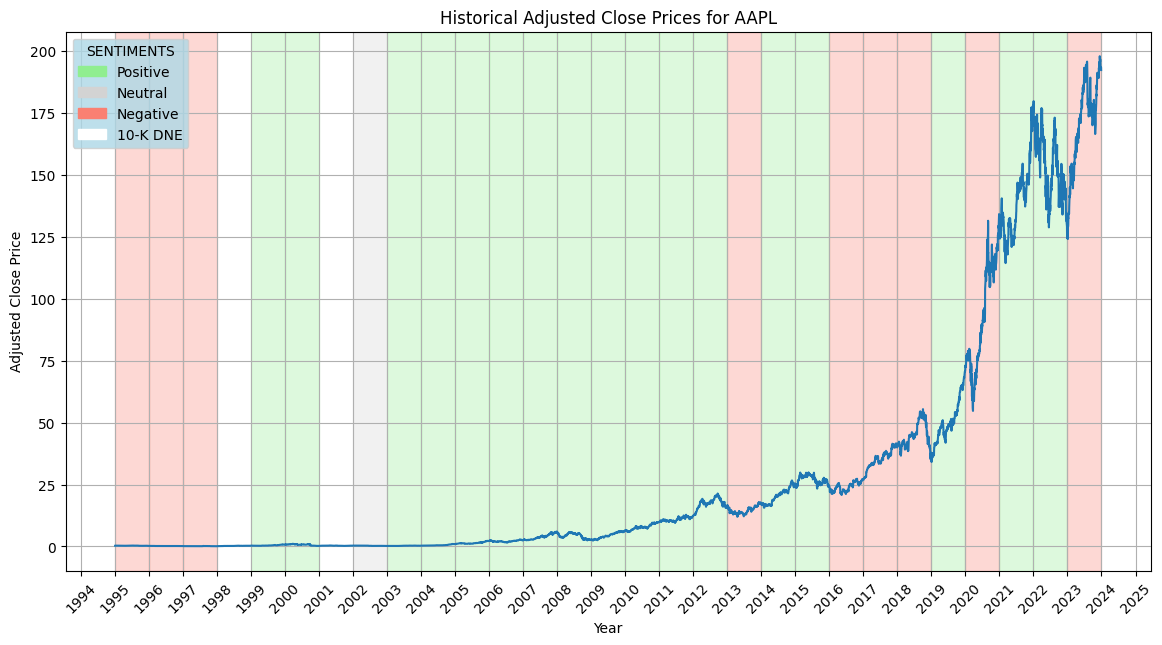

[*********************100%%**********************]  1 of 1 completed


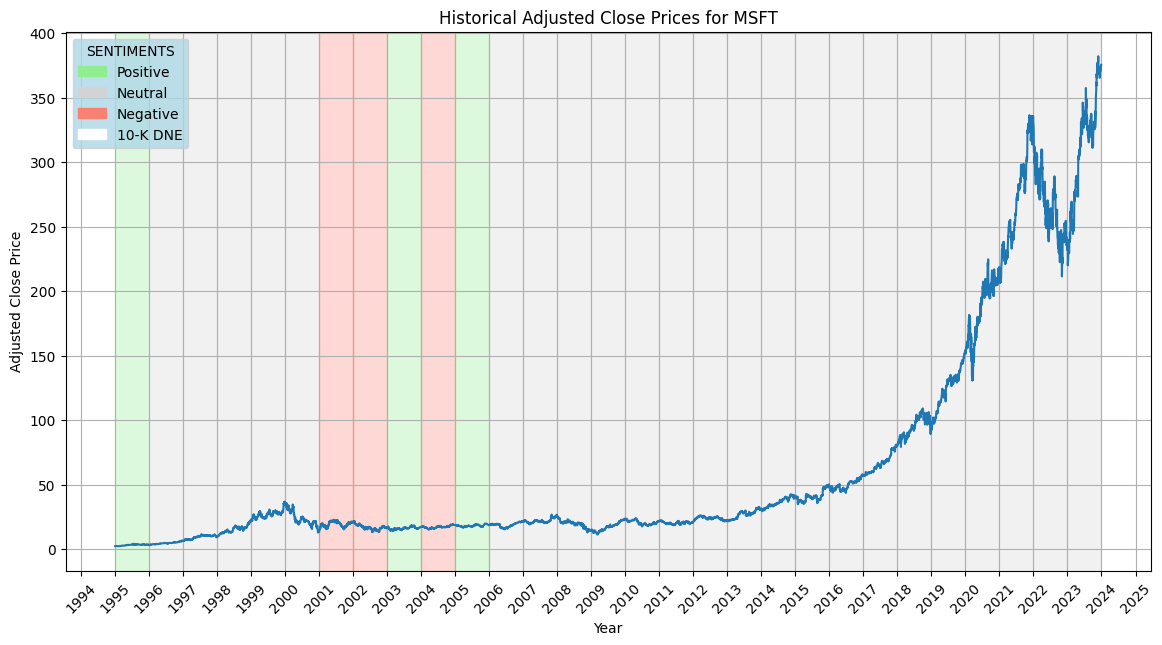

In [39]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import json
from datetime import datetime

# Load sentiment data from JSON files
with open('/content/drive/My Drive/sec_filings/summaries_AAPL_sentiments.json', 'r') as file:
    aapl_sentiments = json.load(file)

with open('/content/drive/My Drive/sec_filings/summaries_MSFT_sentiments.json', 'r') as file:
    msft_sentiments = json.load(file)

def plot_stock(ticker, start_date, end_date, sentiments):
    # Download the stock data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Plot the adjusted close price
    plt.figure(figsize=(14, 7))  # Set the figure size for better readability
    plt.plot(data['Adj Close'], label=f'Adjusted Close - {ticker}')

    # Set major ticks format
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Add sentiment color intervals
    sentiment_colors = {
        'positive': 'lightgreen',
        'neutral': 'lightgray',
        'negative': 'salmon',
        'unknown': 'white'
    }
    # Create patches for each sentiment, including unknown
    patches = [Patch(color=color, label=f'{label.capitalize()}' if label != 'unknown' else '10-K DNE') for label, color in sentiment_colors.items()]
    for year, sentiment in sentiments.items():
        start = datetime.strptime(year + '-01-01', '%Y-%m-%d')
        end = datetime.strptime(year + '-12-31', '%Y-%m-%d')
        plt.axvspan(start, end, color=sentiment_colors[sentiment], alpha=0.3)

    # Add grid, legend, and labels
    plt.grid(True)
    # plt.legend(handles=[Patch(color='blue', label='Adjusted Close')] + patches)
    plt.title(f'Historical Adjusted Close Prices for {ticker}')
    plt.xlabel('Year')
    plt.ylabel('Adjusted Close Price')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    # Add legend for sentiments
    plt.legend(handles=patches, title="SENTIMENTS", frameon=True, facecolor='lightblue')
    plt.show()


    # plt.show()

# Plot data for Apple with sentiments
plot_stock('AAPL', '1995-01-01', '2023-12-31', aapl_sentiments)

# Plot data for Microsoft with sentiments
plot_stock('MSFT', '1995-01-01', '2023-12-31', msft_sentiments)